# "Buckling_Analysis"
### A Tool for *Modeling*, *Bracing* & *Buckling Analysis*
### of *Rectangular 2D Frames*  
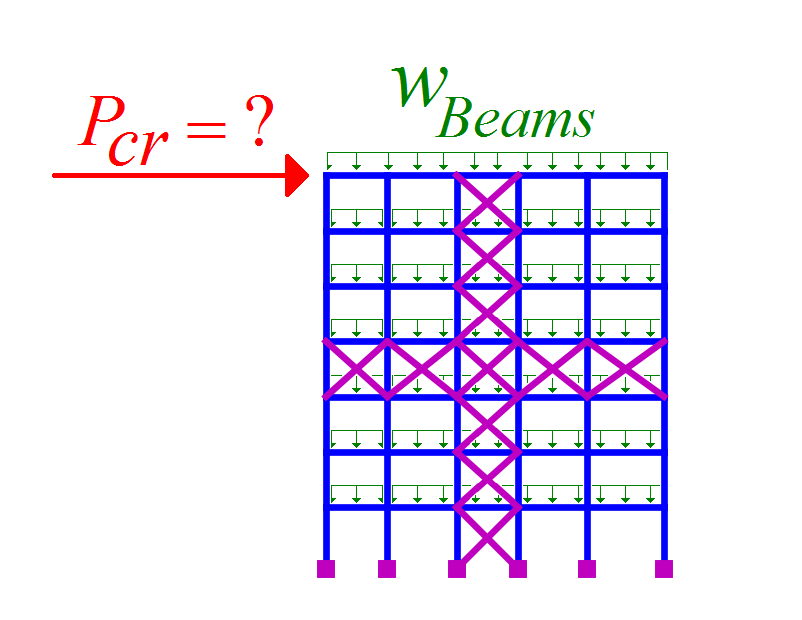
##### 

In [1]:
# (auto) importing modules needed

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sympy import *
import copy


##### 
### Structure Data (input)

In [2]:
# (input)
 
nStory      = 7                              # number of stories

hStory_typ  = 3600                           # height of typical stories (mm)
hStory_Base = 4000                           # height of base_floor (mm)                         

wBay = [  4000, 4500, 4000, 4500, 5000 ]     # width of bays ( any amount )
   
Braced_Bays    = [ 3  ]                      # Doubly (X) Braced  Bays              
Braced_Stories = [ 4  ]                      # Doubly (X) Braced Storys  

# sections:
# All Columns:    IPBv 220:  A=14900 (mm2)    I=146.0*10**6 (mm4) 
# All Beams:      IPE  300:  A= 5380 (mm2)    I= 83.6*10**6 (mm4) 
# All Diagonals:  UPE  120:  A= 1700 (mm2)   

E_Cols, E_Beams, E_Diags = 200,200,200       # Modulus of Elasticity (KN/mm2)
A_Cols, A_Beams, A_Diags = 14900,5380,1700   # Area (mm2)  
I_Cols, I_Beams          = 146e6,83.6e6      # Moment of Inertia (mm4) 

W_Beams = 0.01                               # rectangular Distributed Load on Beams (KN/mm)
                                             # towards Ground is +ve 

##### 
### Structure Data (auto)  

In [3]:
# (auto) Checking & completing

hStory    = np.ones( (nStory,1) ) * hStory_typ     
hStory[0] = hStory_Base

nBay = len(wBay)    # number of bays

Braced_Bays = sorted( Braced_Bays )
keep = []
for i in Braced_Bays:
    if i <= nBay: keep.append(i)
    else: print('\n Warning!',
                '\n Bay', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Bays' )
Braced_Bays = sorted(keep)  

Braced_Stories = sorted( Braced_Stories )
keep = []
for i in Braced_Stories:
    if i <= nStory: keep.append(i)
    else: print('\n Warning!',
                '\n Story', i, "does not exist thus can't be braced.", 
                i, 'is removed from Braced_Stories' )
Braced_Stories = sorted(keep) 

#####   
### Points & Connectivity Matrices

In [4]:
# (auto) Making Frame 

# defining a function called PC 
# to calculate Points & Connectivity matrices of Columns, beams and diagonals 

def PC( wBay, hStory, Braced_Bays, Braced_Stories ): 
    
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i
        Xwalk.append(w)
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i
        Ywalk.append(h) 
    X=len(Xwalk)
    Y=len(Ywalk) 
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y):
        for i in range(0,X):
            x.append( int(Xwalk[i]) )
            y.append( int(Ywalk[j]) )
            index.append(idx)
            idx = idx+1
    Dict = {  'x': x
            , 'y': y  }
    Points = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index = [],[],[]
    idx=0
    for j in range(0,Y-1): 
        for i in range(0,X): 
            x.append( int(i+j*X)   )
            y.append( int(i+j*X+X) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y }
    CnC = pd.DataFrame( data=Dict, index=index )
    
    x,y, index = [],[],[]
    idx=0
    for j in range(1,Y):
        for i in range(0,X-1): 
            p0 = i + j*X
            p1 = p0 + 1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y
           }
    CnB = pd.DataFrame( data=Dict, index=index ) 
    
    x,y, index = [],[],[]
    idx=0
    for b in Braced_Bays:
        for j in range(0,Y-1): 
            p0 = b-1 + j*X
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            p0 = b + j*X
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y }
    CnD_Bays = pd.DataFrame( data=Dict, index=index )

    x,y, index = [],[],[]
    idx=0
    for b in Braced_Stories:
        for i in range(0,X-1): 
            p0 = (b-1)*X + i
            p1 = p0 + X+1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
            p0 = (b-1)*X + i+1
            p1 = p0 + X-1
            x.append( int(p0) )
            y.append( int(p1) )
            index.append(idx)
            idx = idx+1
    Dict = {  'from_point': x
            , 'to_point': y } 
    CnD_Stories = pd.DataFrame( data=Dict, index=index )    
    
    CnD = pd.concat([CnD_Bays,CnD_Stories],axis=0)
    CnD.index = range(0,len(CnD))
    
    # finding & removing duplicates in CnD
    Dup=[] 
    for i in range(0,len(CnD)):
        for j in range(i+1,len(CnD)):
            if CnD.iloc[i,0]==CnD.iloc[j,0]:
                if CnD.iloc[i,1]==CnD.iloc[j,1]:
                    Dup.append(j)
    CnD = CnD.drop(Dup)
    CnD.index = range(0,len(CnD)) 
    CnD = CnD.astype(int) 
    return [ Points, CnC, CnB, CnD ]

[ Points, CnC, CnB, CnD ] = PC( wBay, hStory, Braced_Bays, Braced_Stories ) 

##### 
### Plotting Structure Shape

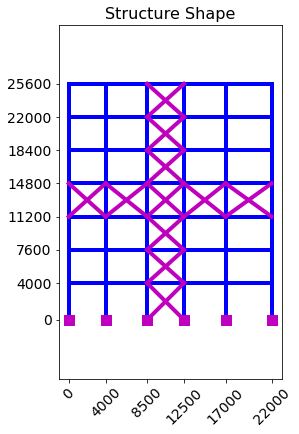

In [5]:
# define a function called Shape
# to check shape of frame

def  Shape( Points, CnC, CnB, CnD, wBay, hStory ):
    
    fig, ax = plt.subplots( figsize=(4,6.5) )
    
    for i in CnC.index: 
        i0 = CnC.loc[i,'from_point']
        i1 = CnC.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnB.index: 
        i0 = CnB.loc[i,'from_point']
        i1 = CnB.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='b', ls='-' )
        
    for i in CnD.index: 
        i0 = CnD.loc[i,'from_point']
        i1 = CnD.loc[i,'to_point'  ]
        x0 = Points.loc[i0,'x']
        x1 = Points.loc[i1,'x']
        y0 = Points.loc[i0,'y']
        y1 = Points.loc[i1,'y']
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( #marker='o', markersize=15, mec='m', mew=1, mfc='m',
                 x, y, lw=4, c='m', ls='-' )

    GroundPoints = Points[ Points.loc[:,'y']==0 ]  
    for i in GroundPoints.index:  
        x0 = GroundPoints.loc[i,'x']
        x1 = GroundPoints.loc[i,'x']
        y0 = GroundPoints.loc[i,'y']
        y1 = GroundPoints.loc[i,'y'] 
        x = [x0,x1]
        y = [y0,y1]
        ax.plot( x, y, lw=5, c='m', ls='-'
                , marker='s', markersize=10, mec='m', mew=1, mfc='m')   
        
    # title
    plt.title( 'Structure Shape', fontsize=16 )
    
    # xticks
    Xwalk = [0]
    for i in wBay:
        w = Xwalk[-1] + i 
        Xwalk.append(w)
    xtks = np.array(Xwalk,dtype='f8')
    ax.set_xticks( xtks )
    plt.xticks(rotation=45,fontsize=14) 
                  
    # yticks
    Ywalk = [0]
    for i in hStory: 
        h = Ywalk[-1] + i 
        Ywalk.append(h)
    ytks = np.array(Ywalk,dtype='f8')
    ax.set_yticks( ytks )
    plt.yticks(rotation=0,fontsize=14)
    
    ax.axis('equal')
    plt.savefig('Check_Shape.png', dpi=120) 
    plt.show()
        
Shape( Points, CnC, CnB, CnD, wBay, hStory )

#####   
### Finding Static Coefficients

In [6]:
# (auto) Coefficients
# define a function called Static_Coeff 
# to find Static Analysis Coefficients: 
#
#   NOP:    Number Of Points
#   NOD:    Number of "Degrees of freedom"
#   RD:     Restrained "Degrees of freedom"
#   FD:     Free "Degrees of freedom"
#   NFD:    Number of Free "Degrees of Freedom"
#   NC:     Number of Columns
#   NB:     Number of Beams
#   ND:     Number of Diagonals(braces)
#   IndxC:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all columns
#   IndxB:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all beams
#   IndxD:  ['near_x','near_y','near_z','far_x','far_y','far_z']  of  all diagonals (braces)
 
def Static_Coeff( Points, CnC, CnB, CnD, wBay ):
    
    # NOP NOD RD FD NFD
    NOP=Points.shape[0]; NOD=NOP*3;
    X=len(wBay)+1; RD=sorted(list(range(0,3*X))); NRD=len(RD)
    FD=range(NRD,NOD); NFD=len(FD)
    
    # NX
    NC, NB, ND = CnC.shape[0],  CnB.shape[0],  CnD.shape[0]
    
    # IndxC
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NC ):
        c0.append( 3*CnC.iloc[i,0]+0 )
        c1.append( 3*CnC.iloc[i,0]+1 )
        c2.append( 3*CnC.iloc[i,0]+2 )
        c3.append( 3*CnC.iloc[i,1]+0 )
        c4.append( 3*CnC.iloc[i,1]+1 )
        c5.append( 3*CnC.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxC = pd.DataFrame( data=Dict, index=index )
    
    # IndxB
    c0,c1,c2, c3,c4,c5 = [],[],[], [],[],[]
    index, idx = [], 0  
    for i in range( 0, NB ):
        c0.append( 3*CnB.iloc[i,0]+0 )
        c1.append( 3*CnB.iloc[i,0]+1 )
        c2.append( 3*CnB.iloc[i,0]+2 )
        c3.append( 3*CnB.iloc[i,1]+0 )
        c4.append( 3*CnB.iloc[i,1]+1 )
        c5.append( 3*CnB.iloc[i,1]+2 )
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  ,  'near_z' : c2
            , 'far_x' :c3  ,  'far_y' :c4  ,  'far_z'  : c5
        }
    IndxB = pd.DataFrame( data=Dict, index=index )    
    
    # IndxD
    c0,c1,    c3,c4 = [],[],    [],[] 
    index, idx = [], 0  
    for i in range( 0, ND ):
        c0.append( 3*CnD.iloc[i,0]+0 )
        c1.append( 3*CnD.iloc[i,0]+1 ) 
        c3.append( 3*CnD.iloc[i,1]+0 )
        c4.append( 3*CnD.iloc[i,1]+1 ) 
        index.append(idx)
        idx = idx+1 
    Dict = {  'near_x':c0  ,  'near_y':c1  
            , 'far_x' :c3  ,  'far_y' :c4  
        }
    IndxD = pd.DataFrame( data=Dict, index=index )
    
    return [NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD]


[NOP, NOD, RD, FD, NFD, NC, NB, ND, IndxC, IndxB, IndxD] = Static_Coeff( Points, CnC, CnB, CnD, wBay )

#####   
### Assigning

In [7]:
# (auto) define a function called Elements
# to asign material & shape Properties & distributed load 
# to columns, beams and trusses

def Elements(
      NB, IndxB, E_Beams, A_Beams, I_Beams, W_Beams
    , NC, IndxC, E_Cols,  A_Cols,  I_Cols
    , ND, IndxD, E_Diags, A_Diags ):
    
    EC = np.ones( [NC,1],'f4' ) * E_Cols
    AC = np.ones( [NC,1],'f4' ) * A_Cols
    IC = np.ones( [NC,1],'f4' ) * I_Cols
    
    EB = np.ones( [NB,1],'f4' ) * E_Beams
    AB = np.ones( [NB,1],'f4' ) * A_Beams
    IB = np.ones( [NB,1],'f4' ) * I_Beams
    WB = np.ones( [NB,1],'f4' ) * W_Beams
    
    ED = np.ones( [ND,1],'f4' ) * E_Diags
    AD = np.ones( [ND,1],'f4' ) * A_Diags
    
    Beams     = IndxB[ ['far_x','far_y'] ].copy();   
    Columns   = IndxC[ ['far_x','far_y'] ].copy();   
    Diagonals = IndxD[ ['far_x','far_y'] ].copy();
    
    Beams['E'] = EB;      Columns['E'] = EC;      Diagonals['E'] = ED;
    Beams['A'] = AB;      Columns['A'] = AC;      Diagonals['A'] = AD;
    Beams['I'] = IB;      Columns['I'] = IC;
    Beams['W'] = WB;    
    
    Beams = Beams.drop(['far_x','far_y'],axis=1)
    Columns = Columns.drop(['far_x','far_y'],axis=1)
    Diagonals = Diagonals.drop(['far_x','far_y'],axis=1)
     
    return [Beams, Columns, Diagonals]


# assigning properties & load to elements
[ Beams, Columns, Diagonals ] = Elements( NB, IndxB, E_Beams, A_Beams, I_Beams, W_Beams
                                         , NC, IndxC, E_Cols,  A_Cols,  I_Cols
                                         , ND, IndxD, E_Diags, A_Diags )

##### 
### Nodal Forces

In [8]:
# Nodal Forces

def Nodal_Forces( Roof_Load, NOD, nStory, nBay ): 
    
    NF = np.zeros([NOD,2],'float64')
    NF = pd.DataFrame( NF,columns = ['Load','Dummy'] )
    
    X   = nBay+1
    Deg = nStory*X*3
    NF.loc[ Deg, 'Load' ] = Roof_Load 
        
    return NF

# assigning nodal forces to nodes
Roof_Load = 1
NF = Nodal_Forces( Roof_Load, NOD, nStory, nBay )

#####   
### Elastic Stiffness Matrices 

In [9]:
# (auto) defining Stiffness Matrices

def ke_frame( A, E, I, L ):
    EI, EA, L2, L3 = E*I, E*A, L**2, L**3
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ] 
    c = {  'c1': [ EA/L   , 0        ,  0      , -1*EA/L,  0       ,  0       ]
         , 'c2': [ 0      , 12*EI/L3 ,  6*EI/L2,  0     , -12*EI/L3,  6*EI/L2 ]
         , 'c3': [ 0      , 6*EI/L2  ,  4*EI/L ,  0     , -6*EI/L2 ,  2*EI/L  ]
         , 'c4': [-1*EA/L , 0        ,  0      ,  EA/L  ,  0       ,  0       ]
         , 'c5': [ 0      , -12*EI/L3, -6*EI/L2,  0     ,  12*EI/L3, -6*EI/L2 ]  
         , 'c6': [ 0      , 6*EI/L2  , 2*EI/L  ,  0     , -6*EI/L2 ,  4*EI/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def ke_truss( A, E, L ):
    x = E*A/L
    r = [  'c1', 'c2', 'c3', 'c4'  ] 
    c = {  'c1': [  x  ,  0  , -x  ,  0  ]  
         , 'c2': [  0  ,  0  ,  0  ,  0  ]
         , 'c3': [ -x  ,  0  ,  x  ,  0  ]
         , 'c4': [  0  ,  0  ,  0  ,  0  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df 

def kg_frame( P, L ):
    x, L2 = P/L, L**2
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6'  ]  
    c = {  'c1': [  P/L ,     0    ,      0      , -P/L ,     0    ,     0      ]
         , 'c2': [   0  ,  1.2*P/L ,     P/10    ,   0  , -1.2*P/L ,    P/10    ]
         , 'c3': [   0  ,    P/10  ,  2*(P*L)/15 ,   0  , -P/10    , -(P*L)/30  ]
         , 'c4': [ -P/L ,     0    ,      0      ,  P/L ,    0     ,     0      ]
         , 'c5': [   0  , -1.2*P/L ,    -P/10    ,   0  , 1.2*P/L  ,   -P/10    ]  
         , 'c6': [   0  ,    P/10  ,   -P*L/30   ,   0  ,  -P/10   , 2*(P*L)/15 ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def kg_truss( P, L ): 
    r = [  'c1', 'c2', 'c3', 'c4' ] 
    c = {  'c1': [  P/L  ,   0   , -P/L  ,  0    ]  
         , 'c2': [   0   ,  P/L  ,   0   , -P/L  ]
         , 'c3': [ -P/L  ,   0   ,  P/L  ,  0    ]
         , 'c4': [   0   , -P/L  ,   0   ,  P/L  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df

def T_frame( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4', 'c5', 'c6' ] 
    c = {  'c1': [  c  ,  s  ,   0  ,  0  ,  0  ,   0  ]  
         , 'c2': [ -s  ,  c  ,   0  ,  0  ,  0  ,   0  ]
         , 'c3': [  0  ,  0  ,   1  ,  0  ,  0  ,   0  ]
         , 'c4': [  0  ,  0  ,   0  ,  c  ,  s  ,   0  ]
         , 'c5': [  0  ,  0  ,   0  , -s  ,  c  ,   0  ]
         , 'c6': [  0  ,  0  ,   0  ,  0  ,  0  ,   1  ]
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T 

def T_truss( c, s ): 
    r = [  'c1', 'c2', 'c3', 'c4' ] 
    c = {  'c1': [  c  ,  s  ,  0  ,  0  ]  
         , 'c2': [ -s  ,  c  ,  0  ,  0  ]
         , 'c3': [  0  ,  0  ,  c  ,  s  ]
         , 'c4': [  0  ,  0  , -s  ,  c  ] 
         }  
    df = pd.DataFrame( data=c , index=r )
    return df.T

#####  
### Ke & Qf

In [10]:
# (auto) defining a function called KeQf
# to form:
#    Elastic Stiffness Matrices, Ke, for all elements
#    External Distributed Loads Matrix, Qf

def KeQf(  Points,  NOD
         , CnB, NB, IndxB, Beams 
         , CnC, NC, IndxC, Columns
         , CnD, ND, IndxD, Diagonals ):
    
    # Empty Ke Qf
    KE = np.zeros([NOD,NOD],'float64')
    KE = pd.DataFrame( KE,columns = np.arange(0,NOD) )
    QF = np.zeros([NOD,2],'float64')
    QF = pd.DataFrame( QF,columns = ['Load','Dummy'] )
    
    # Assigning Properties 
    LC,  TC,  keC,  KeC            =  [],[],[],[]
    LB,  TB,  keB,  KeB, qfB, QfB  =  [],[],[],[],[],[]
    LD,  TD,  keD,  KeD            =  [],[],[],[]   
    
    for i in range(0,NC): 
        dx = Points.iloc[CnC.iloc[i,1],0]-Points.iloc[CnC.iloc[i,0],0]
        dy = Points.iloc[CnC.iloc[i,1],1]-Points.iloc[CnC.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LC.append(L)
        E  = Columns.loc[i,'E'];      
        A  = Columns.loc[i,'A'];         
        I  = Columns.loc[i,'I'];         
        c,s= dx/L, dy/L;    
        T  = T_frame(c,s);           TC.append(T)
        Indx = list(IndxC.iloc[i,:])
        ke = ke_frame(A,E,I,L);      keC.append(ke)   
        Ke = T.T @ ke @ T;           KeC.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values; 
        
    for i in range(0,NB): 
        dx = Points.iloc[CnB.iloc[i,1],0]-Points.iloc[CnB.iloc[i,0],0]
        dy = Points.iloc[CnB.iloc[i,1],1]-Points.iloc[CnB.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LB.append(L)
        E  = Beams.loc[i,'E'];      
        A  = Beams.loc[i,'A'];         
        I  = Beams.loc[i,'I'];          
        w  = Beams.loc[i,'W'];          
        c,s= dx/L, dy/L;
        T  = T_frame(c,s);           TB.append(T)
        Indx = list(IndxB.iloc[i,:])
        qf   = [0,w*L/2,w*L**2/12,0,w*L/2,-w*L**2/12] 
        Dict = {'qf':qf, 'dummy':np.zeros(6,'float')}
        qf = pd.DataFrame( data=Dict, index=range(0,6) ) 
        qfB.append(qf)
        Qf = T.T @ qf['qf'].values;                              
        QF.loc[Indx,'Load'] = QF.loc[Indx,'Load'] + Qf.values;
        ke = ke_frame(A,E,I,L);      keB.append(ke)   
        Ke = T.T @ ke @ T;           KeB.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values; 
        
    for i in range(0,ND): 
        dx = Points.iloc[CnD.iloc[i,1],0]-Points.iloc[CnD.iloc[i,0],0]
        dy = Points.iloc[CnD.iloc[i,1],1]-Points.iloc[CnD.iloc[i,0],1]
        L  = (dx**2+dy**2)**0.5;     LD.append(L)
        E  = Diagonals.loc[i,'E'];      
        A  = Diagonals.loc[i,'A'];         
        c,s= dx/L, dy/L;    
        T  = T_truss(c,s);           TD.append(T)
        Indx = list(IndxD.iloc[i,:])
        ke = ke_truss(A,E,L);        keD.append(ke)   
        Ke = T.T @ ke @ T;           KeD.append(Ke)
        KE.iloc[Indx,Indx] = KE.iloc[Indx,Indx]+Ke.values;
        
    Columns['L']   = LC
    Beams['L']     = LB
    Diagonals['L'] = LD
    Diagonals['L'] = round( Diagonals['L'],-1 )
    
    return [ KE,QF, LC,TC,keC,KeC, LB,TB,keB,KeB,qfB, LD,TD,keD,KeD ] 


# Ke Qf 
[ KE,QF, LC,TC,keC,KeC, LB,TB,keB,KeB,qfB, LD,TD,keD,KeD ] = KeQf( 
        Points,  NOD
      , CnB, NB, IndxB, Beams 
      , CnC, NC, IndxC, Columns
      , CnD, ND, IndxD, Diagonals )

#####   
### P-Delta Analysis

In [11]:
# (auto) define a function called P-Delta
# Which Performs P-Delta Analysis on Frame
# and returng Global Geometry Matrix, KG 
# and number of Iterations.

def P_Delta( 
      NF,  NOD,  FD, KE, QF   
    , NC, IndxC, TC, keC, KeC, Columns
    , NB, IndxB, TB, keB, KeB, Beams, qfB
    , ND, IndxD, TD, keD, KeD, Diagonals  ):
    
    #eps
    eps = 1.0e-6;
    
    # Col
    N = NC
    Old = np.zeros(N,'float64');
    New = np.ones(N,'float64');
    Dict = {'Old':Old,'New':New}
    qAxialCol = pd.DataFrame(data=Dict,index=np.arange(0,N))
    # Beam
    N = NB
    Old = np.zeros(N,'float64');
    New = np.ones(N,'float64');
    Dict = {'Old':Old,'New':New}
    qAxialBeam = pd.DataFrame(data=Dict,index=np.arange(0,N))
    # Diag
    N = ND
    Old = np.zeros(N,'float64');
    New = np.ones(N,'float64');
    Dict = {'Old':Old,'New':New} 
    qAxialDiag = pd.DataFrame(data=Dict,index=np.arange(0,N))
    
    nIter = 0
    while ( nIter<=20
            and
           ( sum( abs(qAxialBeam['New']-qAxialBeam['Old']) )>eps 
             or
             sum( abs(qAxialCol['New']- qAxialCol['Old'])  )>eps )
           ): 
        nIter = nIter+1
        print( 'Iteration', nIter )
         
        # Kg
        Kg = np.zeros([NOD,NOD],'float64') 
        
        # Empty Ke Qf
        KG = np.zeros([NOD,NOD],'float64')
        KG = pd.DataFrame( KG,columns = np.arange(0,NOD) ) 
    
        # Assigning Properties 
        kgC,  KgC  =  [],[] 
        kgB,  KgB  =  [],[] 
        kgD,  KgD  =  [],[] 
        
        # Col
        for i in range(0,NC): 
            E  = Columns.loc[i,'E']      
            A  = Columns.loc[i,'A']         
            I  = Columns.loc[i,'I']         
            L  = Columns.loc[i,'L']  
            T  = TC[i]  
            P  = qAxialCol.loc[i,'New']
            Indx = list(IndxC.iloc[i,:])
            kg = kg_frame(P,L);      kgC.append(kg)   
            Kg = T.T @ kg @ T;       KgC.append(Kg)
            KG.iloc[Indx,Indx] = KG.iloc[Indx,Indx]+Kg.values;
            
        # Beam
        for i in range(0,NB): 
            E  = Beams.loc[i,'E']      
            A  = Beams.loc[i,'A']         
            I  = Beams.loc[i,'I']         
            L  = Beams.loc[i,'L']  
            T  = TB[i]  
            P  = qAxialBeam.loc[i,'New']
            Indx = list(IndxB.iloc[i,:])
            kg = kg_frame(P,L);      kgB.append(kg)   
            Kg = T.T @ kg @ T;       KgB.append(Kg)
            KG.iloc[Indx,Indx] = KG.iloc[Indx,Indx]+Kg.values;
        
        # Diag
        for i in range(0,ND): 
            E  = Diagonals.loc[i,'E']      
            A  = Diagonals.loc[i,'A']          
            L  = Diagonals.loc[i,'L']  
            T  = TD[i]  
            P  = qAxialDiag.loc[i,'New']
            Indx = list(IndxD.iloc[i,:])
            kg = kg_truss(P,L);      kgD.append(kg)   
            Kg = T.T @ kg @ T;       KgD.append(Kg)
            KG.iloc[Indx,Indx] = KG.iloc[Indx,Indx]+Kg.values;
            
        ## k  kX KX  
        K=KE+KG 
        
        kC, KC = [],[];
        for i in range(0,NC): 
            kC.append( keC[i]+kgC[i] )
            KC.append( KeC[i]+KgC[i] )
            
        kB, KB = [],[];
        for i in range(0,NB): 
            kB.append( keB[i]+kgB[i] )
            KB.append( KeB[i]+KgB[i] )
        
        kD, KD = [],[];
        for i in range(0,ND): 
            kD.append( keD[i]+kgD[i] )
            KD.append( KeD[i]+KgD[i] )    
         
        # Kred
        Kred = K.iloc[FD,FD]
        
        # U
        U = np.zeros([NOD,2],'float64')
        U = pd.DataFrame( U,columns = ['dis','Dummy'] ) 
         
        ## Gauss Ellimination  ax=b => x=?
        a = Kred.values
        b = (  NF.loc[FD,'Load'] - QF.loc[FD,'Load']  ).values
        n = len(b)
        x = np.zeros(n,'float64')

        #    Forward Elimination
        for k in range(n-1):
            for i in range(k+1,n):
                fctr = a[i,k] / a[k,k]
                for j in range(k,n):
                    a[i,j] = a[i,j] - fctr*a[k,j]
                b[i] = b[i] - fctr*b[k]
        
        #    Back Substitution
        x[n-1] = b[n-1] / a[n-1,n-1]
        for i in range(n-2,-1,-1):
            Sum = b[i]
            for j in range(i+1,n):
                Sum = Sum - a[i,j]*x[j]
            x[i] = Sum / a[i,i]
           
        # U    
        U.loc[FD,'dis'] = x.copy()
          
        ## member forces 
        #    Col
        uC,UC,qC = [],[],[]
        for i in range(0,NC):
            Indx = list(IndxC.iloc[i,:])
            T    = TC[i] 
            k    = kC[i] 
            UC.append(  U.loc[Indx,'dis'].values  )    
            uC.append( T @ UC[-1] )
            qC.append( k @ uC[-1] )  
        qAxialCol.loc[:,'Old'] = qAxialCol.loc[:,'New']
        New=[]
        for i in range(0,NC): New.append(qC[i][3])
        qAxialCol.loc[:,'New'] = New 
       
        #    Beam
        uB,UB,qB = [],[],[]
        for i in range(0,NB):
            Indx = list(IndxB.iloc[i,:])
            T    = TB[i] 
            k    = kB[i] 
            UB.append(  U.loc[Indx,'dis'].values  )    
            uB.append( T @ UB[-1] )
            qB.append( k @ uB[-1] )  
        qAxialBeam.loc[:,'Old'] = qAxialBeam.loc[:,'New']
        New=[]
        for i in range(0,NB): New.append(qB[i][3])
        qAxialBeam.loc[:,'New'] = New
        
        #    Diag
        uD,UD,qD = [],[],[]
        for i in range(0,ND):
            Indx = list(IndxD.iloc[i,:])
            T    = TD[i] 
            k    = kD[i] 
            UD.append(  U.loc[Indx,'dis'].values  )    
            uD.append( T @ UD[-1] )
            qD.append( k @ uD[-1] )  
        qAxialDiag.loc[:,'Old'] = qAxialDiag.loc[:,'New']
        New=[]
        for i in range(0,ND): New.append(qD[i][2])
        qAxialDiag.loc[:,'New'] = New  
    
    # Checking nLoop
    if nIter>20: print('\n Warning! \n No Convergence after 20 iterations.')
    else       : print( 'P-Delta Analysis Converged after', nIter, 'Iterations' )   
    
    return [ nIter, KG ]


# P-Delta Analysis (Checking)
[ nIter, KG ] = P_Delta( 
      NF,  NOD,  FD, KE, QF   
    , NC, IndxC, TC, keC, KeC, Columns
    , NB, IndxB, TB, keB, KeB, Beams, qfB
    , ND, IndxD, TD, keD, KeD, Diagonals  )

Iteration 1
Iteration 2
Iteration 3
Iteration 4
P-Delta Analysis Converged after 4 Iterations


#####   
### Buckling Analysis

In [12]:
# define a function called Buckling_Load 
# which returns the Buckling Load

def Buckling_Load( KE, KG, FD ):
    from scipy import linalg 
    
    alpha=[ 0.0001, 0.001, 0.01, 0.1, 1 ]
    nIter=0
    while nIter <= 20:
        alpha.append( alpha[-1]*10 )
        # assigning nodal forces to nodes
        Roof_Load = 1 * alpha[-1]
        NF = Nodal_Forces( Roof_Load, NOD, nStory, nBay )
        print('\nCkecking P =',Roof_Load )
        # P-Delta
        nIter, KG = P_Delta(
              NF,  NOD,  FD, KE, QF   
            , NC, IndxC, TC, keC, KeC, Columns
            , NB, IndxB, TB, keB, KeB, Beams, qfB
            , ND, IndxD, TD, keD, KeD, Diagonals  )
    
    alpha=[ alpha[-5], alpha[-4], alpha[-3], alpha[-2] ]
    nIter = 0
    while nIter <= 20:
        alpha.append( alpha[-1]*2 )
        # assigning nodal forces to nodes
        Roof_Load = 1 * alpha[-1]
        NF = Nodal_Forces( Roof_Load, NOD, nStory, nBay )
        print('\nCkecking P =',Roof_Load )
        # P-Delta
        nIter, KG = P_Delta(
              NF,  NOD,  FD, KE, QF   
            , NC, IndxC, TC, keC, KeC, Columns
            , NB, IndxB, TB, keB, KeB, Beams, qfB
            , ND, IndxD, TD, keD, KeD, Diagonals  )
        
    alpha=[ alpha[-4], alpha[-3], alpha[-2] ]
    nIter = 0
    while nIter <= 20:
        alpha.append( alpha[-1]*1.1 )
        # assigning nodal forces to nodes
        Roof_Load = 1 * alpha[-1]
        NF = Nodal_Forces( Roof_Load, NOD, nStory, nBay )
        print('\nCkecking P =',Roof_Load )
        # P-Delta
        nIter, KG = P_Delta(
              NF,  NOD,  FD, KE, QF   
            , NC, IndxC, TC, keC, KeC, Columns
            , NB, IndxB, TB, keB, KeB, Beams, qfB
            , ND, IndxD, TD, keD, KeD, Diagonals  )
        
        
    alpha=[ alpha[-3], alpha[-2] ]
    nIter = 0
    while nIter <= 20:
        alpha.append( alpha[-1]*1.05 )
        # assigning nodal forces to nodes
        Roof_Load = 1 * alpha[-1]
        NF = Nodal_Forces( Roof_Load, NOD, nStory, nBay )
        print('\nCkecking P =',Roof_Load )
        # P-Delta
        nIter, KG = P_Delta(
              NF,  NOD,  FD, KE, QF   
            , NC, IndxC, TC, keC, KeC, Columns
            , NB, IndxB, TB, keB, KeB, Beams, qfB
            , ND, IndxD, TD, keD, KeD, Diagonals  )  
    
    return round( alpha[-2], -1 )

Pcr = Buckling_Load( KE, KG, FD )
print( '\nPcr = ',Pcr )


Ckecking P = 10
Iteration 1
Iteration 2
Iteration 3
Iteration 4
P-Delta Analysis Converged after 4 Iterations

Ckecking P = 100
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
P-Delta Analysis Converged after 5 Iterations

Ckecking P = 1000
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
P-Delta Analysis Converged after 6 Iterations

Ckecking P = 10000
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
P-Delta Analysis Converged after 10 Iterations

Ckecking P = 100000
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21

 Warning! 
 No Convergence after 20 iterations.

Ckecking P = 20000
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
It

#####   